*Luis Antonio Ortega Andrés   
Antonio Coín Castro*

# Classification using Random and Nyström features

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the use of Random Fourier features and Nystöm features with linear SVMs to carry out non-linear classification.

In [57]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.gaussian_process.kernels import Matern

import pandas as pd

import kernel_approximation as ka

%load_ext autoreload
%autoreload 2

seed = 0
np.random.seed(seed)  # for reproducible results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def plot_decision_regions(X, y, grid_x1, grid_x2, features_grid, clf):
    """Plot decision regions of a classifier 'clf'."""
    Z = clf.decision_function(features_grid)
    Z = Z.reshape(grid_x1.shape)

    plt.imshow(Z, interpolation='nearest',
               extent=(grid_x1.min(), grid_x1.max(),
                       grid_x2.min(), grid_x2.max()),
               aspect='auto',
               origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(grid_x1, grid_x2, Z, levels=[0],
                           linewidths=2, linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y,
                cmap=plt.cm.Paired, edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis([np.min(grid_x1), np.max(grid_x1),
              np.min(grid_x2), np.max(grid_x2)])
    plt.show()

## Create dataset

In [4]:
"""
# A simple 2-D problem
np.random.seed(0)
n_samples = 300
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
"""

# A not so simple 2-D problem

noise = 0.3

# Training set
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Compute grid of points for plotting the decision regions
grid_x1, grid_x2 = np.meshgrid(
    np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50),
)
grid_X = np.c_[grid_x1.ravel(), grid_x2.ravel()]

## Non-linear SVM (sklearn)

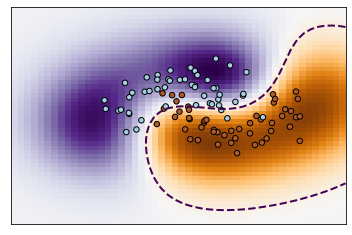

In [5]:
gamma = 0.5
sigma = np.sqrt(1.0/2.0/gamma)

clf = svm.SVC(kernel='rbf', gamma=gamma)
# clf = svm.NuSVC(gamma=gamma)
clf.fit(X, y)

plot_decision_regions(X, y, grid_x1, grid_x2, grid_X, clf)

## RBF Random Features (sklearn)

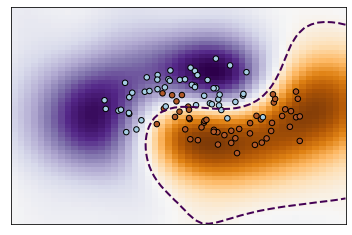

In [6]:
n_random_features = 10000

rbf_sampler = RBFSampler(
    gamma=gamma, n_components=n_random_features, random_state=1)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.fit_transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

## RBF Random Features (our implementation)

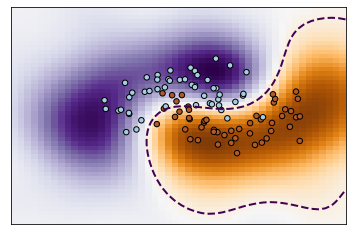

In [7]:
rbf_sampler = ka.RandomFeaturesSamplerRBF(n_random_features, sigma)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

## Matérn Random Features (our implementation)

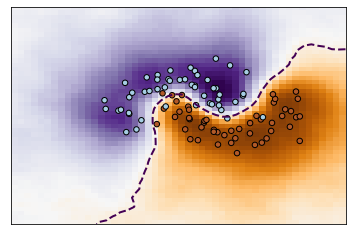

In [8]:
length_scale = sigma
nu = 1.5

matern_sampler = ka.RandomFeaturesSamplerMatern(
    n_random_features, length_scale, nu)
random_features = matern_sampler.fit_transform(X)
random_features_grid = matern_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

## Nyström features (our implementation)

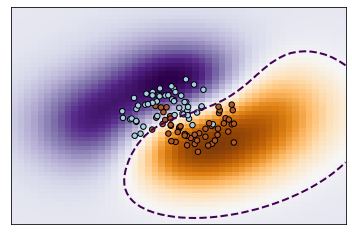

In [11]:
# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma)


n_nystroem_features = 20
# n_nystroem_features = len(X) # Recovers full kernel

nystroem_sampler = ka.NystroemFeaturesSampler(n_nystroem_features, kernel)
nystroem_features = nystroem_sampler.fit_transform(X)
nystroem_features_grid = nystroem_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(nystroem_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, nystroem_features_grid, clf)

## Choosing the optimal hyperparameters and comparing the prediction error

Afer having scaled the data to the range $[-1, 1]$ using sklearn's *MinMaxScaler*, we determine the optimal hyperparameters (gamma, nu) and the optimal number of features for the different classifiers considered in the previous examples, using CV on the training set. We also compare the prediction error of the different classifiers in the test set $\left\{X_{test}, y_{test} \right\}$. 


In [73]:
# Scale data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Set CV parameters
n_folds = 5
folds = StratifiedKFold(
    n_folds, 
    shuffle=True, 
    random_state=seed
)

# Build a Pipeline for each classifier
models = [
    (Pipeline([("svc_sk_rbf", svm.SVC(kernel='rbf', random_state = seed))]), 
                "Non-linear SVM (SKlearn)"),
    (Pipeline([("rbf_sk", RBFSampler(random_state = seed)), 
               ("svc_sk_linear", svm.SVC(kernel='linear', random_state = seed))]), 
                "RBF Random Features (SKlearn) + Linear SVM"),
    (Pipeline([("rbf_features", ka.RandomFeaturesSamplerRBF(random_state = seed)), 
               ("svc", svm.SVC(kernel='linear', random_state = seed))]), 
                "RBF Random Features (our implementation) + Linear SVM"),
    (Pipeline([("matern_features", ka.RandomFeaturesSamplerMatern(random_state = seed)),
               ("svc", svm.SVC(kernel='linear', random_state = seed))]), 
                "Matérn Random Features (our implementation) + Linear SVM"),
    (Pipeline([("nystroem_rbf_features", ka.NystroemFeaturesSampler(random_state = seed)), 
                ("svc", svm.SVC(kernel='linear', random_state = seed))]), 
                "Nyström Features RBF (our implementation) + Linear SVM"),
    (Pipeline([("nystroem_matern_features", ka.NystroemFeaturesSampler(kernel = Matern(), random_state = seed)), 
                ("svc", svm.SVC(kernel='linear', random_state = seed))]), 
                "Nyström Features Mátern (our implementation) + Linear SVM")
]

# Set parameter search space
gamma_logspace = np.logspace(-5, 5, 3)
n_features_space = [10,20, 50,100,500, 1000]
parameters = [
    # Non-linear SVM (SKlearn)
    {"svc_sk_rbf__gamma": gamma_logspace}, 
    # RBF Random Features (SKlearn) + Linear SVM
    {"rbf_sk__gamma": gamma_logspace,      
     "rbf_sk__n_components": n_features_space},
    # RBF Random Features (our implementation) + Linear SVM
    {"rbf_features__sigma": np.sqrt(1.0/2.0 * gamma_logspace), 
     "rbf_features__n_components": n_features_space},
    # Matérn Random Features (our implementation) + Linear SVM"
    {"matern_features__scale": np.sqrt(1.0/2.0 * gamma_logspace), 
     "matern_features__nu": gamma_logspace/2, 
     "matern_features__n_components": n_features_space},
    # Nyström Features RBF (our implementation) + Linear SVM
    {"nystroem_rbf_features__n_components": n_features_space},
    # Nyström Features Mátern (our implementation) + Linear SVM
    {"nystroem_matern_features__n_components": n_features_space}
]

#DONE: añadir kernel matern en Nyström
#ON GOING: gráficas?
fit_times = []

for (model, name), param_grid in zip(models, parameters):
    print("--", name, "--")
    clf = GridSearchCV(model, param_grid, cv=folds)
    clf.fit(X, y)
    print("  Best parameters", clf.best_params_)
    print(f"  Training score: {clf.best_score_:.3f}")


    idx = [s for s in clf.cv_results_.keys() if "n_components" in s]
    if idx:
        df = pd.DataFrame(clf.cv_results_)
        fit_time = df.groupby(idx[0]).mean()["mean_fit_time"].to_numpy()
        fit_times.append((fit_time, name))


-- Non-linear SVM (SKlearn) --
  Best parameters {'svc_sk_rbf__gamma': 1e-05}
  Training score: 0.860
-- RBF Random Features (SKlearn) + Linear SVM --
  Best parameters {'rbf_sk__gamma': 1.0, 'rbf_sk__n_components': 10}
  Training score: 0.880
-- RBF Random Features (our implementation) + Linear SVM --
  Best parameters {'rbf_features__n_components': 10, 'rbf_features__sigma': 0.00223606797749979}
  Training score: 0.860
-- Matérn Random Features (our implementation) + Linear SVM --
  Best parameters {'matern_features__n_components': 100, 'matern_features__nu': 0.5, 'matern_features__scale': 0.7071067811865476}
  Training score: 0.910
-- Nyström Features RBF (our implementation) + Linear SVM --
  Best parameters {'nystroem_rbf_features__n_components': 10}
  Training score: 0.830
-- Nyström Features Mátern (our implementation) + Linear SVM --
  Best parameters {'nystroem_matern_features__n_components': 20}
  Training score: 0.890


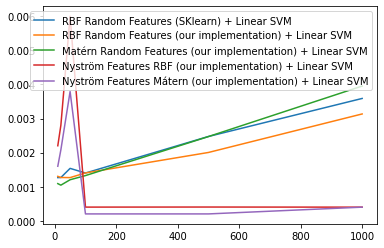

In [72]:
for times, name in fit_times:
    plt.plot(n_features_space, times, label = name)

plt.legend()
plt.show()

## References

https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

